In [52]:
from math import sqrt
from scipy import stats
from pydataset import data
from datetime import datetime


from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import sklearn.metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from env import host, user, password
from acquire import get_telco_data, get_telco_df
from prepare import prep_telco

## Data Acquistion
 -Will be using functions from our acquire.py to build our pandas dataframes from SQL and form local CSV files

In [73]:
telco_df = get_telco_df()  ##displaying head of the dataframe just built using our get_telco_df
                           ## function which connects to SQL and reads the table into a 
                           ## pandas dataframe and creates a local CSV file.

In [74]:
telco_df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,...,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,...,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,...,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,...,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,...,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


In [66]:
def col_range(df):
    stats_df = df.describe().T
    stats_df['range'] = stats_df['max'] - stats_df['min']
    return stats_df

In [67]:
def summarize_df(df):
    print(f'This dataframe has {df.shape[0]} rows and {df.shape[1]} columns.')
    print('-------------------------------------------')
    print(df.info())
    print('-------------------------------------------')
    print(col_range(df))

In [68]:
summarize_df(telco_df)

This dataframe has 7043 rows and 24 columns.
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             704

In [69]:
telco_df.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_type_id,7043.0,2.315633,1.148907,1.00,1.0,2.00,3.00,4.00
internet_service_type_id,7043.0,1.872923,0.737796,1.00,1.0,2.00,2.00,3.00
contract_type_id,7043.0,1.690473,0.833755,1.00,1.0,1.00,2.00,3.00
senior_citizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
monthly_charges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [70]:
def df_value_counts(df):
    for col in df.columns:
        if df[col].dtype == object:
            print(df[col].value_counts())
            print("-----------------")

In [71]:
df_value_counts(telco_df)

3523-BRGUW    1
9529-OFXHY    1
0195-IESCP    1
0220-EBGCE    1
7295-JOMMD    1
             ..
2969-QWUBZ    1
5729-KLZAR    1
6368-NWMCE    1
9944-HKVVB    1
7971-HLVXI    1
Name: customer_id, Length: 7043, dtype: int64
-----------------
Male      3555
Female    3488
Name: gender, dtype: int64
-----------------
No     3641
Yes    3402
Name: partner, dtype: int64
-----------------
No     4933
Yes    2110
Name: dependents, dtype: int64
-----------------
Yes    6361
No      682
Name: phone_service, dtype: int64
-----------------
No                  3390
Yes                 2971
No phone service     682
Name: multiple_lines, dtype: int64
-----------------
No                     3498
Yes                    2019
No internet service    1526
Name: online_security, dtype: int64
-----------------
No                     3088
Yes                    2429
No internet service    1526
Name: online_backup, dtype: int64
-----------------
No                     3095
Yes                    2422
No inter

## Data Preparation

In [76]:
telco_df.total_charges = telco_df.total_charges.str.replace(' ', '0').astype(float)
telco_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security           7043 non-null   object 
 12  online_backup             7043 non-null   object 
 13  device_protection         7043 non-null   object 
 14  tech_sup

In [80]:
cols = ['payment_type_id',
 'internet_service_type_id',
 'contract_type_id',
 'gender',
 'senior_citizen',
 'partner',
 'dependents',
 'tenure',
 'phone_service',
 'multiple_lines',
 'online_security',
 'online_backup',
 'device_protection',
 'tech_support',
 'streaming_tv',
 'streaming_movies',
 'paperless_billing',
 'monthly_charges',
 'total_charges',
 'churn',
 'contract_type',
 'internet_service_type',
 'payment_type']

In [88]:
def graph_distributions(df):
    for col in df[cols]:
        plt.hist(df[col])
        plt.title(f'Distribution of {col}')
        plt.ylabel('Number of Customers')
        plt.xlabel(f'{col}: values')
        plt.show()

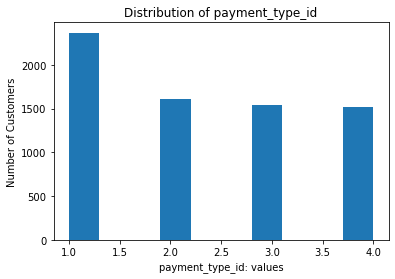

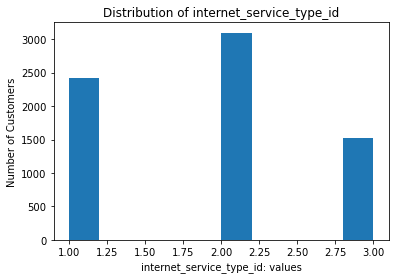

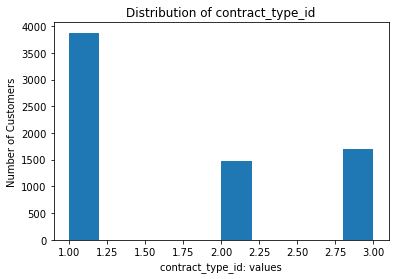

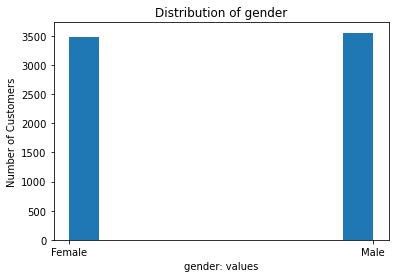

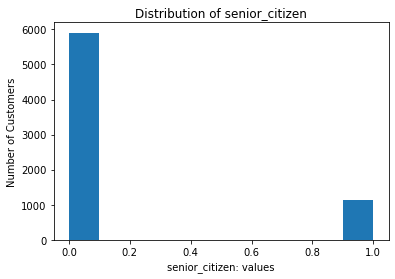

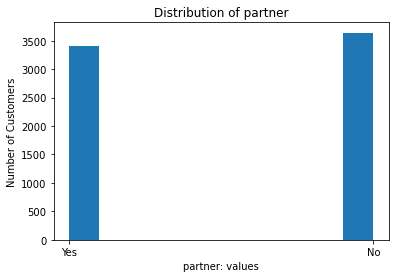

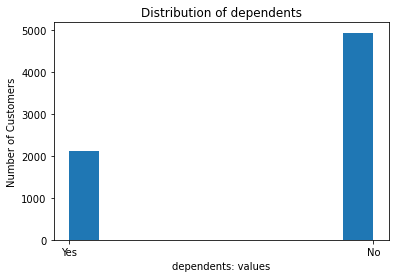

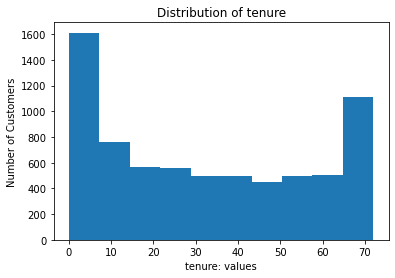

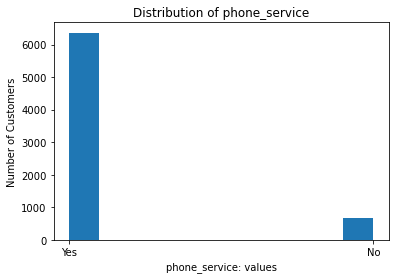

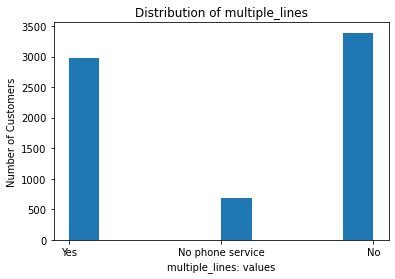

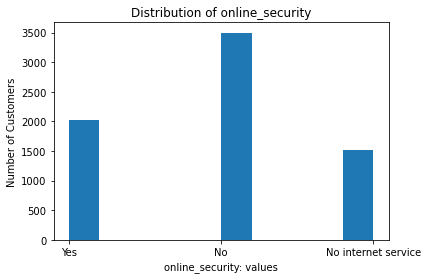

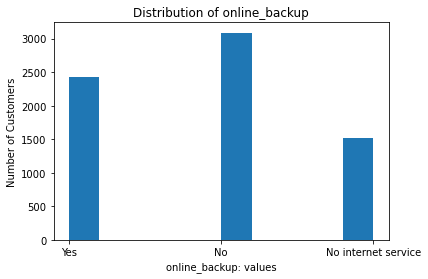

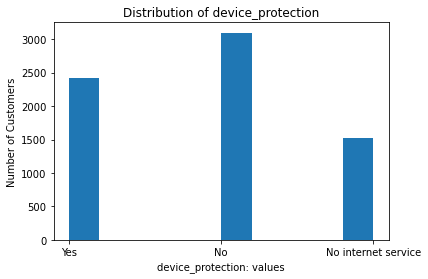

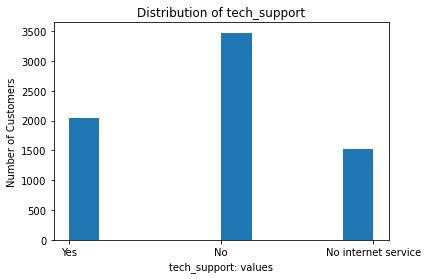

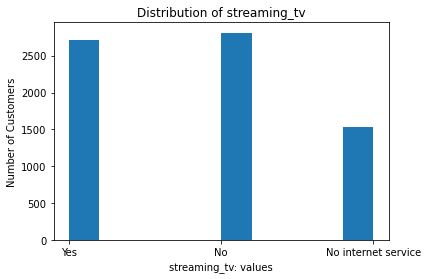

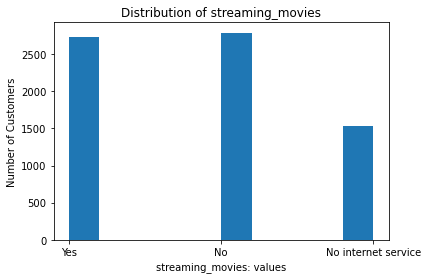

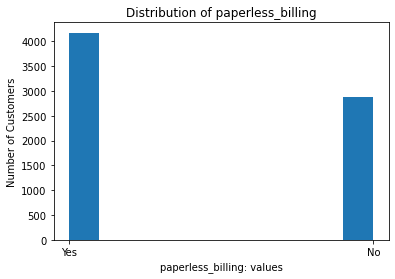

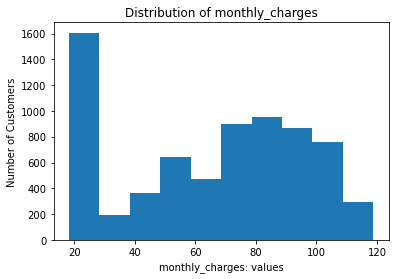

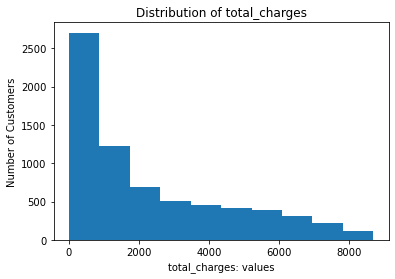

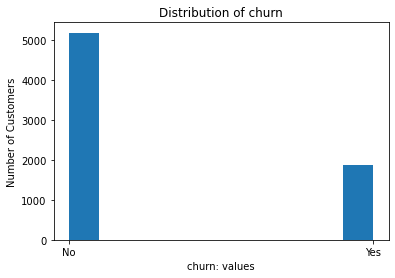

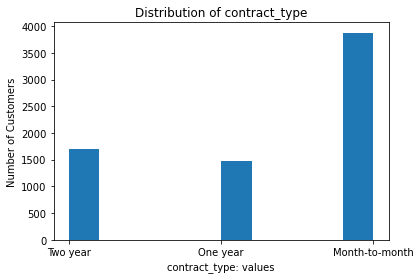

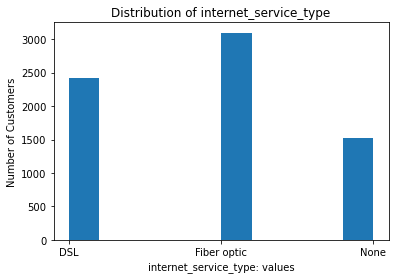

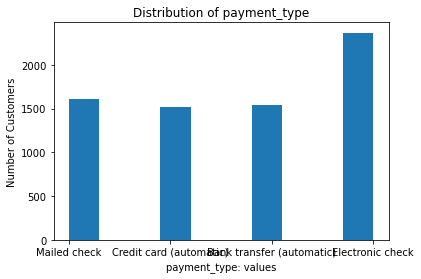

In [89]:
graph_distributions(telco_df)